In [1]:
import pygame
import os
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt
from matplotlib import animation
from collections import deque

pygame 2.6.1 (SDL 2.28.4, Python 3.9.21)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
print(torch.cuda.is_available())  # 應該為 True
print(torch.version.cuda)         # 應該列出 CUDA 版本
print(torch.backends.cudnn.version())  # cuDNN 版本


True
12.1
90100


In [3]:
script_dir = os.path.join(os.getcwd(), 'space_ship_game_RL')
if script_dir not in sys.path:
    sys.path.append(script_dir)

from setting import *
from game import Game


In [ ]:
class SpaceShipEnv():
    def __init__(self):
        pygame.init()
        pygame.font.init()

        # 延後畫面初始化，等 render() 時才設置
        self.screen = None
        self.clock = pygame.time.Clock()
        self.fps = FPS

        self.game = Game()

        self.action_space = [0, 1, 2, 3]
        self.observation = self.game.state
        
        # 獎勵計算變數
        self.last_score = 0
        self.last_health = 100
        self.score_milestones = set()
        
        # 射擊獎勵變數
        self.last_bullet_count = 0
        self.last_enemy_count = 0
        self.consecutive_no_shoot = 0
        
        # 步數和效率追蹤
        self.step_count = 0
        self.max_steps = 15000  # 最大步數限制

    def step(self, action):
        self.step_count += 1
        # 記錄動作前的狀態
        prev_enemy_count = len(self.game.enemies) if hasattr(self.game, 'enemies') else 0

        self.game.update(action)

        if self.screen is None:
            self.game.draw()
        else:
            self.game.draw(self.screen)
            self.clock.tick(self.fps)

        state = self.game.state
        reward = 0
        
        # 1. 分數獎勵
        score_gain = self.game.score - self.last_score
        reward += score_gain * 2.0
        self.last_score = self.game.score
        
        # 2. 血量懲罰
        current_health = self.game.player.sprite.health
        health_change = current_health - self.last_health
        if health_change < 0:
            health_ratio = current_health / 100.0
            base_penalty = abs(health_change) * 10.0
            # 血量越低懲罰越重
            if health_ratio < 0.5:  # 血量低於50%
                multiplier = 2.0 - health_ratio
                reward -= base_penalty * multiplier
            else:
                reward -= base_penalty
                
        self.last_health = current_health
        
        # 3. 死亡懲罰
        if current_health <= 0:
            reward -= 200 # 固定死亡懲罰
            
        # 4. 里程碑獎勵
        milestones = [100, 500, 1000, 2000, 5000, 10000]
        for milestone in milestones:
            if (self.game.score >= milestone and 
                milestone not in self.score_milestones):
                reward += 20  # 固定里程碑獎勵
                self.score_milestones.add(milestone)
                
        # 5. 射擊獎勵
        current_bullet_count = len(self.game.player.sprite.bullets) if hasattr(self.game.player.sprite, 'bullets') else 0
        current_enemy_count = len(self.game.enemies) if hasattr(self.game, 'enemies') else 0
        # 檢測是否擊中敵人
        if current_enemy_count < prev_enemy_count and score_gain > 0:
            enemy_killed = prev_enemy_count - current_enemy_count
            reward += enemy_killed * 20.0
            
        # 6. 存活獎勵
        if current_health > 0:
            # 基礎存活獎勵
            base_survival_reward = 0.5
            # 健康獎勵
            health_bonus = (current_health / 100.0) * 0.3
            reward += base_survival_reward + health_bonus
            # 隨分數遞增之存活獎勵
            if self.game.score > 1000:
                reward += 0.2 * (self.game.score / 1000.0)
            
        # 7. 勝利獎勵
        if self.game.score >= 10000:
            reward += 1000
         
        done = not self.game.running or self.game.score >= 10000 or self.step_count >= self.max_steps
        info = self.game.score

        return state, reward, done, info

    def reset(self):
        self.game = Game()
        # reset variables
        self.last_score = 0
        self.last_health = 100
        self.score_milestones.clear()
        self.last_bullet_count = 0
        self.last_enemy_count = 0
        self.consecutive_no_shoot = 0
        self.step_count = 0

        return self.game.state

    def render(self):
        if self.screen is None:
            self.screen = pygame.display.set_mode((WIDTH, HEIGHT))
            pygame.display.set_caption("SpaceShip RL Environment")

    def close(self):
        pygame.quit()

In [5]:
# Hyperparameters
num_episodes = 4000
batch_size = 64
gamma = 0.99
lr = 1e-4
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.999
memory_capacity = 60000  # 100000
target_update_freq = 2000   # 1000

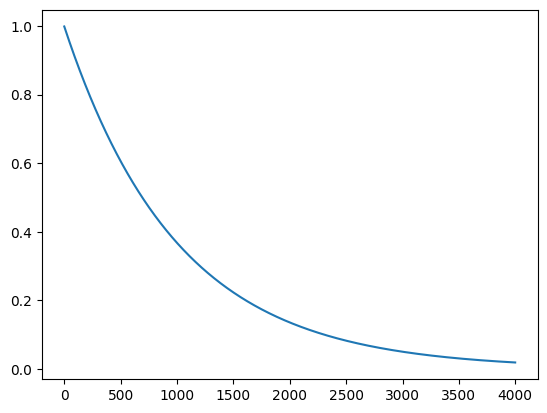

In [6]:
epsilon_list=[]
epsilon=epsilon_start
for i in range(num_episodes):
    epsilon = max(epsilon_end, epsilon * epsilon_decay)
    epsilon_list.append(epsilon)
plt.plot(epsilon_list)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [8]:
# CNN-based DQN Model
class DQN(nn.Module):
    def __init__(self, num_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [9]:
# Replay buffer
# 用於儲存代理人經驗（狀態、動作、獎勵等）的緩衝區，支援隨機抽樣以打破時間相關性，有助於穩定訓練。

class ReplayMemory:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        # Use deque with a fixed capacity to automatically discard the oldest experience when full.
        # 使用 deque 並設定最大長度，當容量滿時會自動移除最舊的資料。

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        # Store a single transition (experience) in the buffer.
        # 儲存一筆經驗（狀態轉移）進緩衝區。

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        # Randomly sample a batch of transitions to break correlation between consecutive samples.
        # 隨機抽取一批經驗，打破樣本間的時間關聯性，提高訓練穩定性。

        # Unpack each element into separate tensors for network input
        # 將 batch 拆解成分別的 tensor 以供神經網路訓練
        states, actions, rewards, next_states, dones = zip(*batch)
        
        # Convert the sampled data into tensors and move them to the specified device (CPU or GPU)
        # 將抽樣資料轉成 tensor 並移至指定設備（CPU/GPU）
        states = torch.tensor(np.stack(states), dtype=torch.float32, device=device)
        actions = torch.tensor(actions, dtype=torch.int64, device=device)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
        next_states = torch.tensor(np.stack(next_states), dtype=torch.float32, device=device)
        dones = torch.tensor(dones, dtype=torch.float32, device=device)
        
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)
        # Return the current size of the buffer.
        # 回傳緩衝區目前儲存的資料數量。


In [10]:
# Preprocess frames (grayscale and resize to 84x84)
# 預處理影格：轉為灰階並縮放為 84x84

def preprocess_frame(frame):
    # frame 是 numpy array (H, W, 3)，先轉為 PIL Image
    # Input is a color image (RGB), convert to PIL format for easier processing.
    # 輸入是彩色圖像（RGB），轉成 PIL Image 以方便處理。
    image = Image.fromarray(frame)

    # 轉灰階
    # Convert the image to grayscale to reduce input complexity.
    # 將影像轉為灰階，降低輸入維度與計算量。
    image = image.convert('L')

    # resize 成 84x84
    # Resize the image to a standard 84x84 shape, as per DQN convention.
    # 依照 DQN 的慣例將影像統一縮放至 84x84。
    image = image.resize((84, 84), Image.Resampling.BILINEAR)  # or NEAREST, or LANCZOS

    # 轉回 numpy 並正規化
    # Convert back to NumPy and normalize pixel values to [0, 1].
    # 轉回 NumPy 格式並將像素值標準化到 [0, 1]。
    frame = np.asarray(image, dtype=np.float32) / 255.0

    return frame


def stack_frames(stacked_frames, state, is_new_episode):
    # 預處理目前影格
    frame = preprocess_frame(state)

    if is_new_episode or stacked_frames is None:
        # If it's a new episode or no previous frames, initialize with 4 identical frames
        # 若是新的一集或是尚未初始化，則用目前影格複製 4 次形成初始堆疊
        stacked_frames = deque([frame]*4, maxlen=4)
    else:
        # 否則把新影格加入到堆疊中，自動捨棄最舊的
        stacked_frames.append(frame)

    # Stack the 4 frames along the first dimension: shape becomes (4, 84, 84)
    # 沿著第一維（channel）堆疊成 4 通道輸入：形狀變成 (4, 84, 84)
    stacked_state = np.stack(stacked_frames, axis=0)

    return stacked_state, stacked_frames


In [11]:
# 初始化 Breakout 環境 / Initialize the Breakout environment
env = SpaceShipEnv()
num_actions = len(env.action_space)

# 建立策略網路與目標網路 / Create policy and target networks
policy_net = DQN(num_actions).to(device)
target_net = DQN(num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())  # 初始時讓目標網路等於策略網路
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=lr)
memory = ReplayMemory(memory_capacity)

# 載入模型（若有）
if os.path.exists('checkpoint.pth'):
    checkpoint = torch.load('checkpoint.pth', map_location=device)
    policy_net.load_state_dict(checkpoint['policy_net'])
    target_net.load_state_dict(checkpoint['target_net'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_episode = checkpoint['episode'] + 1
    total_steps = checkpoint['total_steps']
    best_score = checkpoint['best_score']
    epsilon = checkpoint['epsilon']
    reward_history = checkpoint['reward_history']
    score_history = checkpoint['score_history']
    print(f"Loaded checkpoint from episode {start_episode}, best score: {best_score:.2f}, epsilon={epsilon:.3f}")
else:
    start_episode = 0
    total_steps = 0
    best_score = float('-inf')
    epsilon = epsilon_start
    reward_history = []
    score_history = []


# 訓練迴圈 / Training loop
# 每次可以訓練個100步(根據自己的設備與時間調整)，然後下一次都再接續上次的訓練模型接續往下訓練
# You can train for 100 steps each time (adjust according to your own equipment and time), 
# and then continue training from the last training model next time.
for episode in range(start_episode, 4000): # last time = 3200
    state = env.reset()
    state, stacked_frames = stack_frames(None, state, True)
    total_reward, done = 0, False

    while not done:
        # ε-greedy 策略：隨機選擇動作或從模型中選擇 / Epsilon-greedy action selection
        if random.random() < epsilon:
            action = random.choice(env.action_space)
        else:
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                action = policy_net(state_tensor).argmax(dim=1).item()

        # 執行動作 / Perform action
        next_state, reward, done_, score = env.step(action)
        done = done_
        total_reward += reward

        next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
        memory.push(state, action, reward, next_state, done)
        state = next_state

        # 訓練模型 / Train the model from memory
        if len(memory) >= batch_size:
            states, actions, rewards, next_states, dones = memory.sample(batch_size)

            with torch.no_grad():
                target_q = rewards + gamma * target_net(next_states).max(1)[0] * (1 - dones)

            current_q = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            loss = F.mse_loss(current_q, target_q)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # 更新 target 網路 / Periodically update target net
        total_steps += 1
        if total_steps % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

    # 更新 epsilon 並紀錄統計資料 / Decay epsilon and log results
    epsilon = max(epsilon_end, epsilon * epsilon_decay)
    reward_history.append(total_reward)
    score_history.append(score)

    print(f"Episode {episode + 1:3d}, Reward: {total_reward:7.2f}, Score: {score:4d}, Epsilon: {epsilon:5.3f}")

    # 儲存模型（若比目前最佳分數更好，或每 50 回合）
    if (episode + 1) % 50 == 0 or score > best_score:
        best_score = max(best_score, score)

        torch.save({
            'policy_net': policy_net.state_dict(),
            'target_net': target_net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epsilon': epsilon,
            'episode': episode,
            'total_steps': total_steps,
            'best_score': best_score,
            'reward_history': reward_history,
            'score_history': score_history,
        }, 'checkpoint.pth')

        print(f"Checkpoint saved at episode {episode + 1}, best score: {best_score:.2f}")

env.close()


Episode   1, Reward:  -98.96, Score:  558, Epsilon: 0.999
Checkpoint saved at episode 1, best score: 558.00
Episode   2, Reward: -450.19, Score:  540, Epsilon: 0.998
Episode   3, Reward: -883.59, Score:  236, Epsilon: 0.997
Episode   4, Reward: -221.26, Score:  542, Epsilon: 0.996
Episode   5, Reward: -838.29, Score:  348, Epsilon: 0.995
Episode   6, Reward: -492.91, Score:  322, Epsilon: 0.994
Episode   7, Reward: -851.05, Score:  238, Epsilon: 0.993
Episode   8, Reward: -308.61, Score:  632, Epsilon: 0.992
Checkpoint saved at episode 8, best score: 632.00
Episode   9, Reward: -566.99, Score:  420, Epsilon: 0.991
Episode  10, Reward: -1054.50, Score:  362, Epsilon: 0.990
Episode  11, Reward:  653.29, Score:  944, Epsilon: 0.989
Checkpoint saved at episode 11, best score: 944.00
Episode  12, Reward: -1023.13, Score:  258, Epsilon: 0.988
Episode  13, Reward:   15.45, Score:  648, Epsilon: 0.987
Episode  14, Reward: -921.81, Score:  336, Epsilon: 0.986
Episode  15, Reward: -1152.46, Scor

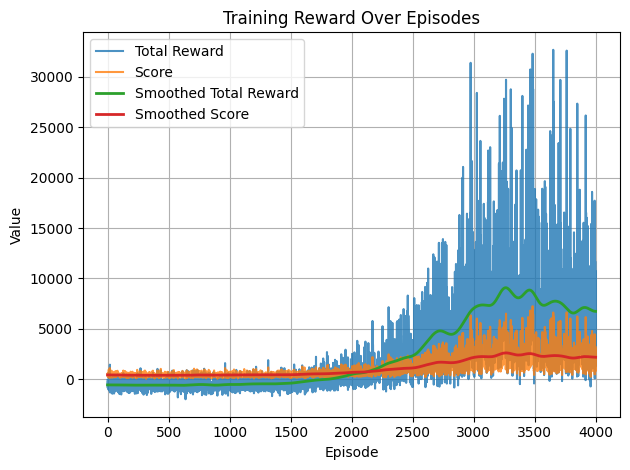

In [12]:
from scipy.ndimage import gaussian_filter1d

reward_smooth = gaussian_filter1d(reward_history, sigma=50)
score_smooth = gaussian_filter1d(score_history, sigma=50)

# 畫圖
# plt.figure(figsize=(10, 5))
plt.plot(reward_history, label='Total Reward', alpha=0.8)
plt.plot(score_history, label='Score', alpha=0.8)
plt.plot(reward_smooth, label='Smoothed Total Reward', linewidth=2)
plt.plot(score_smooth, label='Smoothed Score', linewidth=2)

plt.legend(loc='upper left')
plt.xlabel("Episode")
plt.ylabel("Value")
plt.title("Training Reward Over Episodes")
plt.grid(True)
plt.tight_layout()
# plt.savefig("dqn_training_curve.png")

